In [1]:
# insert rickroll here ayyye

In [2]:
import csv
import os
import requests
import pandas as pd
import tabula
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from statistics import mean

Part 1: Data collection/curation + parsing

We have decided to use two sets of data for this project, each involving many countries around the world: gun ownership,
and a collection of homicide rates. The number of guns possessed by civilians in each country cannot stand alone as an indicator of gun violence, as people
kill other people--guns do not.

The gun ownership data originated from smallarmssurvey.org, an organization that
maintains databases on small arms-related statistics worldwide: violent deaths, firearms holdings, etc. We felt that the
data, given the organization's focus on impartial analysis, would be thorough and well-researched.

The homicide rate data originated from the United Nations Office on Drugs and Crime. We shouldn't need to expand on their
reputation, but the data appears to be extremely thorough.

NOTE: should we look for suicide by gun rates, too? What about population?

In [3]:
# opening the homicide rate file
#NOTE: not sure how to scrape this one off the internet, so downloaded data manually and stuck inside the project
homicide_rates = pd.read_csv('united_nations_homicide_rate_by_mechanisms.csv')

#opening the gun ownership data
url = "http://www.smallarmssurvey.org/fileadmin/docs/Weapons_and_Markets/Tools/Firearms_holdings/SAS-BP-Civilian-held-firearms-annexe.pdf"
got_gun = tabula.io.read_pdf(url, output_format='dataframe', pages='all')

#rename columns
got_gun[0].columns=['country_code', 'country', 'region', 'subregion', 'population', 'total_est_guns', 'est_of_guns_per_100_ppl', 'delete1', 'comp_method', 'registered_guns', 'delete2', 'unregistered_guns']

#drop some unnecessary columns & rows
got_gun[0].drop(range(0,5), inplace=True)
#NOTE: should we delete some other columns? is all of these data relevant for our project?
got_gun[0].drop(columns=['delete1', 'delete2'], inplace=True)

got_gun[0]

,country_code,country,region,subregion,population,total_est_guns,est_of_guns_per_100_ppl,comp_method,registered_guns,unregistered_guns
5,AFG,Afghanistan,Asia,Southern Asia,"34,169,000","4,270,000",12.5,2.0,NaN,NaN
6,ALB,Albania,Europe,Southern Europe,"2,911,000","350,000",12.0,2.0,"65,747","284,253"
7,DZA,Algeria,Africa,Northern Africa,"41,064,000","877,000",2.1,2.0,"200,000","677,000"
8,ASM,American Samoa,Oceania,Polynesia,"56,000",400,0.7,2.0,250,150
9,AND,Andorra,Europe,Southern Europe,"69,000","10,000",14.1,3.0,"7,599","2,401"
...,...,...,...,...,...,...,...,...,...,...
266,VGB,Virgin Islands (U.K.),Americas,Caribbean,"31,000",300,0.8,2.0,48,252
267,VIR,Virgin Islands (U.S.),Americas,Caribbean,"107,000","18,000",16.6,2.0,NaN,NaN
268,YEM,Yemen,Asia,Western Asia,"28,120,000","14,859,000",52.8,2.0,NaN,NaN
269,ZMB,Zambia,Africa,Eastern Africa,"17,238,000","158,000",0.9,2.0,"86,642","71,358"


In [4]:
homicide_rates

,Country,Indicator,Region,Subregion,Unit,Year,Clear,Female Firearm chart,Female Firearms,Female Other,...,Male Other,Male Other chart,Male Sharp,Male Sharp chart,Male Unknown,Male Unknown chart,Number of Records,Onlyrates,rate,Round rate and count
0,India,homicide by Firearms,Asia,Southern Asia,Count,1999,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,"9,294","9,294"
1,India,Firearms rate,Asia,Southern Asia,Rate,1999,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0.9,0.9
2,India,homicide by Firearms,Asia,Southern Asia,Count,2000,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,"8,370","8,370"
3,India,Firearms rate,Asia,Southern Asia,Rate,2000,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0.8,0.8
4,India,homicide by Firearms,Asia,Southern Asia,Count,2001,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,"8,019","8,019"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17603,Australia,Male Homicide by Unknown Mechanisms,Oceania,Australia and New Zealand,Count,2017,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,4,4
17604,Australia,Male Homicide rate by Other Mechanisms,Oceania,Australia and New Zealand,Rate,2017,0,NaN,NaN,NaN,...,0.5,NaN,NaN,NaN,NaN,NaN,1,NaN,0.5,0.5
17605,Australia,Male Homicide rate by Unknown Mechanisms,Oceania,Australia and New Zealand,Rate,2017,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,1,NaN,0,0
17606,Australia,Other Mechanism rate,Oceania,Australia and New Zealand,Rate,2017,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0.3,0.3


Part 2: Data management/representation

In [5]:
regions = homicide_rates['Region'].unique()
rows = []
for row in got_gun[0].iterrows():
    if row[1]['region'] in regions:
        rows.append(row[1])
gun_owners = pd.DataFrame(rows)
gun_owners

,country_code,country,region,subregion,population,total_est_guns,est_of_guns_per_100_ppl,comp_method,registered_guns,unregistered_guns
5,AFG,Afghanistan,Asia,Southern Asia,"34,169,000","4,270,000",12.5,2.0,NaN,NaN
6,ALB,Albania,Europe,Southern Europe,"2,911,000","350,000",12.0,2.0,"65,747","284,253"
7,DZA,Algeria,Africa,Northern Africa,"41,064,000","877,000",2.1,2.0,"200,000","677,000"
8,ASM,American Samoa,Oceania,Polynesia,"56,000",400,0.7,2.0,250,150
9,AND,Andorra,Europe,Southern Europe,"69,000","10,000",14.1,3.0,"7,599","2,401"
...,...,...,...,...,...,...,...,...,...,...
266,VGB,Virgin Islands (U.K.),Americas,Caribbean,"31,000",300,0.8,2.0,48,252
267,VIR,Virgin Islands (U.S.),Americas,Caribbean,"107,000","18,000",16.6,2.0,NaN,NaN
268,YEM,Yemen,Asia,Western Asia,"28,120,000","14,859,000",52.8,2.0,NaN,NaN
269,ZMB,Zambia,Africa,Eastern Africa,"17,238,000","158,000",0.9,2.0,"86,642","71,358"


In [6]:
guns_per_region = {}
for reg in gun_owners['region'].unique():
    guns_per_region[reg] = pd.DataFrame(gun_owners.loc[gun_owners['region'] == reg])

In [7]:
years = {}
for y in homicide_rates['Year'].unique():
    rates = []
    data = homicide_rates.loc[homicide_rates['Year'] == y]
    for row in data.iterrows():
        val = str(row[1]['rate']).replace(",", "")
        val = float(val)
        rates.append(val)
    years[y] = mean(rates)

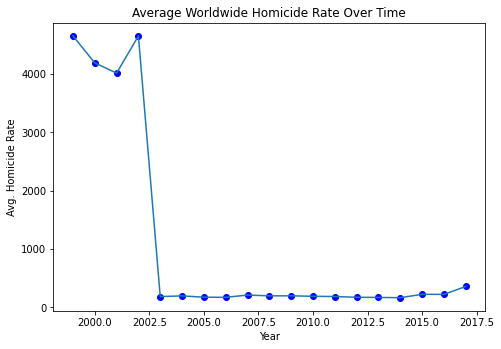

In [8]:
x_year = list(years.keys())
y_val = list(years.values())

fig=plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(x_year, y_val, color="b")
ax.plot(x_year, y_val)

ax.set_xlabel("Year")
ax.set_ylabel("Avg. Homicide Rate")
ax.set_title("Average Worldwide Homicide Rate Over Time")
plt.show()

In [9]:
# TODO -- Left off here (mrp)

Part 3: Exploratory data analysis

In [10]:
#stuff

Part 4: Hypothesis testing & machine learning

In [11]:
#wat

Part 5: Communication of insights attained

In [12]:
#um